In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

### Load the EMH data

In [2]:
ice_age <- read_tsv("../clean_data/ice_age.tsv", progress=FALSE) %>%
    random_call(c("Loschbour", "Stuttgart", "UstIshim")) %>%
    mutate(subst=paste0(ref, "-", alt))
ice_age[ice_age == 9] <- NA

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


### Load the modern data

In [3]:
sgdp <- read_tsv("../clean_data/sgdp.tsv", progress=FALSE) %>%
    select(chrom, pos, ref, alt, S_French_1, S_French_2, S_Sardinian_1, S_Sardinian_2, S_Han_1, S_Han_2) %>% 
    random_call %>%
    mutate(subst=paste0(ref, "-", alt))
names(sgdp)[-(1 : 4)] %<>% str_replace("^S_", "SGDP_")
sgdp[sgdp == 9] <- NA

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


### Summarise the substitution rates for each sample

In [4]:
samples_long <- right_join(ice_age, sgdp) %>%
    select(-c(chrom, pos, ref, alt)) %>%
    gather(sample, snp, -subst) %>% 
    mutate(age=ifelse(str_detect(sample, "^SGDP_"), "modern", "ancient"))

Joining, by = c("chrom", "pos", "ref", "alt", "subst")


In [5]:
subst_rates <-  samples_long %>%
    filter(snp == 2) %>%  # filter for SNPs
    group_by(sample) %>%  mutate(total=n()) %>% # calculate the total number of SNPs per sample
    ungroup %>%
    group_by(sample, subst, total, age) %>% summarise(count=n()) %>% # calculate different substitutions for each sample
    mutate(prop=count / total)  %>% # calculate the proportion
    ungroup

In [6]:
head(subst_rates)

sample,subst,total,age,count,prop
AfontovaGora2,A-C,711,ancient,23,0.03234880
AfontovaGora2,A-G,711,ancient,108,0.15189873
AfontovaGora2,A-T,711,ancient,16,0.02250352
AfontovaGora2,C-A,711,ancient,26,0.03656821
AfontovaGora2,C-G,711,ancient,37,0.05203938
AfontovaGora2,C-T,711,ancient,137,0.19268636


### Counts of SNPs for each sample

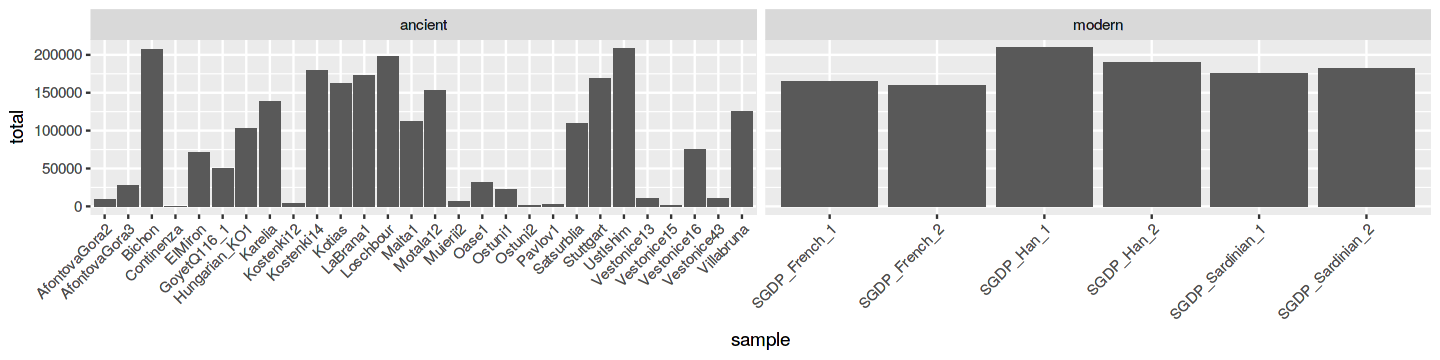

In [7]:
options(repr.plot.width=12, repr.plot.height=3)

ggplot(subst_rates, aes(sample, total)) +
    geom_bar(stat="identity") +
    facet_grid(. ~ age, scales="free_x") +
    theme(axis.text.x=element_text(angle=45, hjust=1))

### Proportions of substitutions in each sample

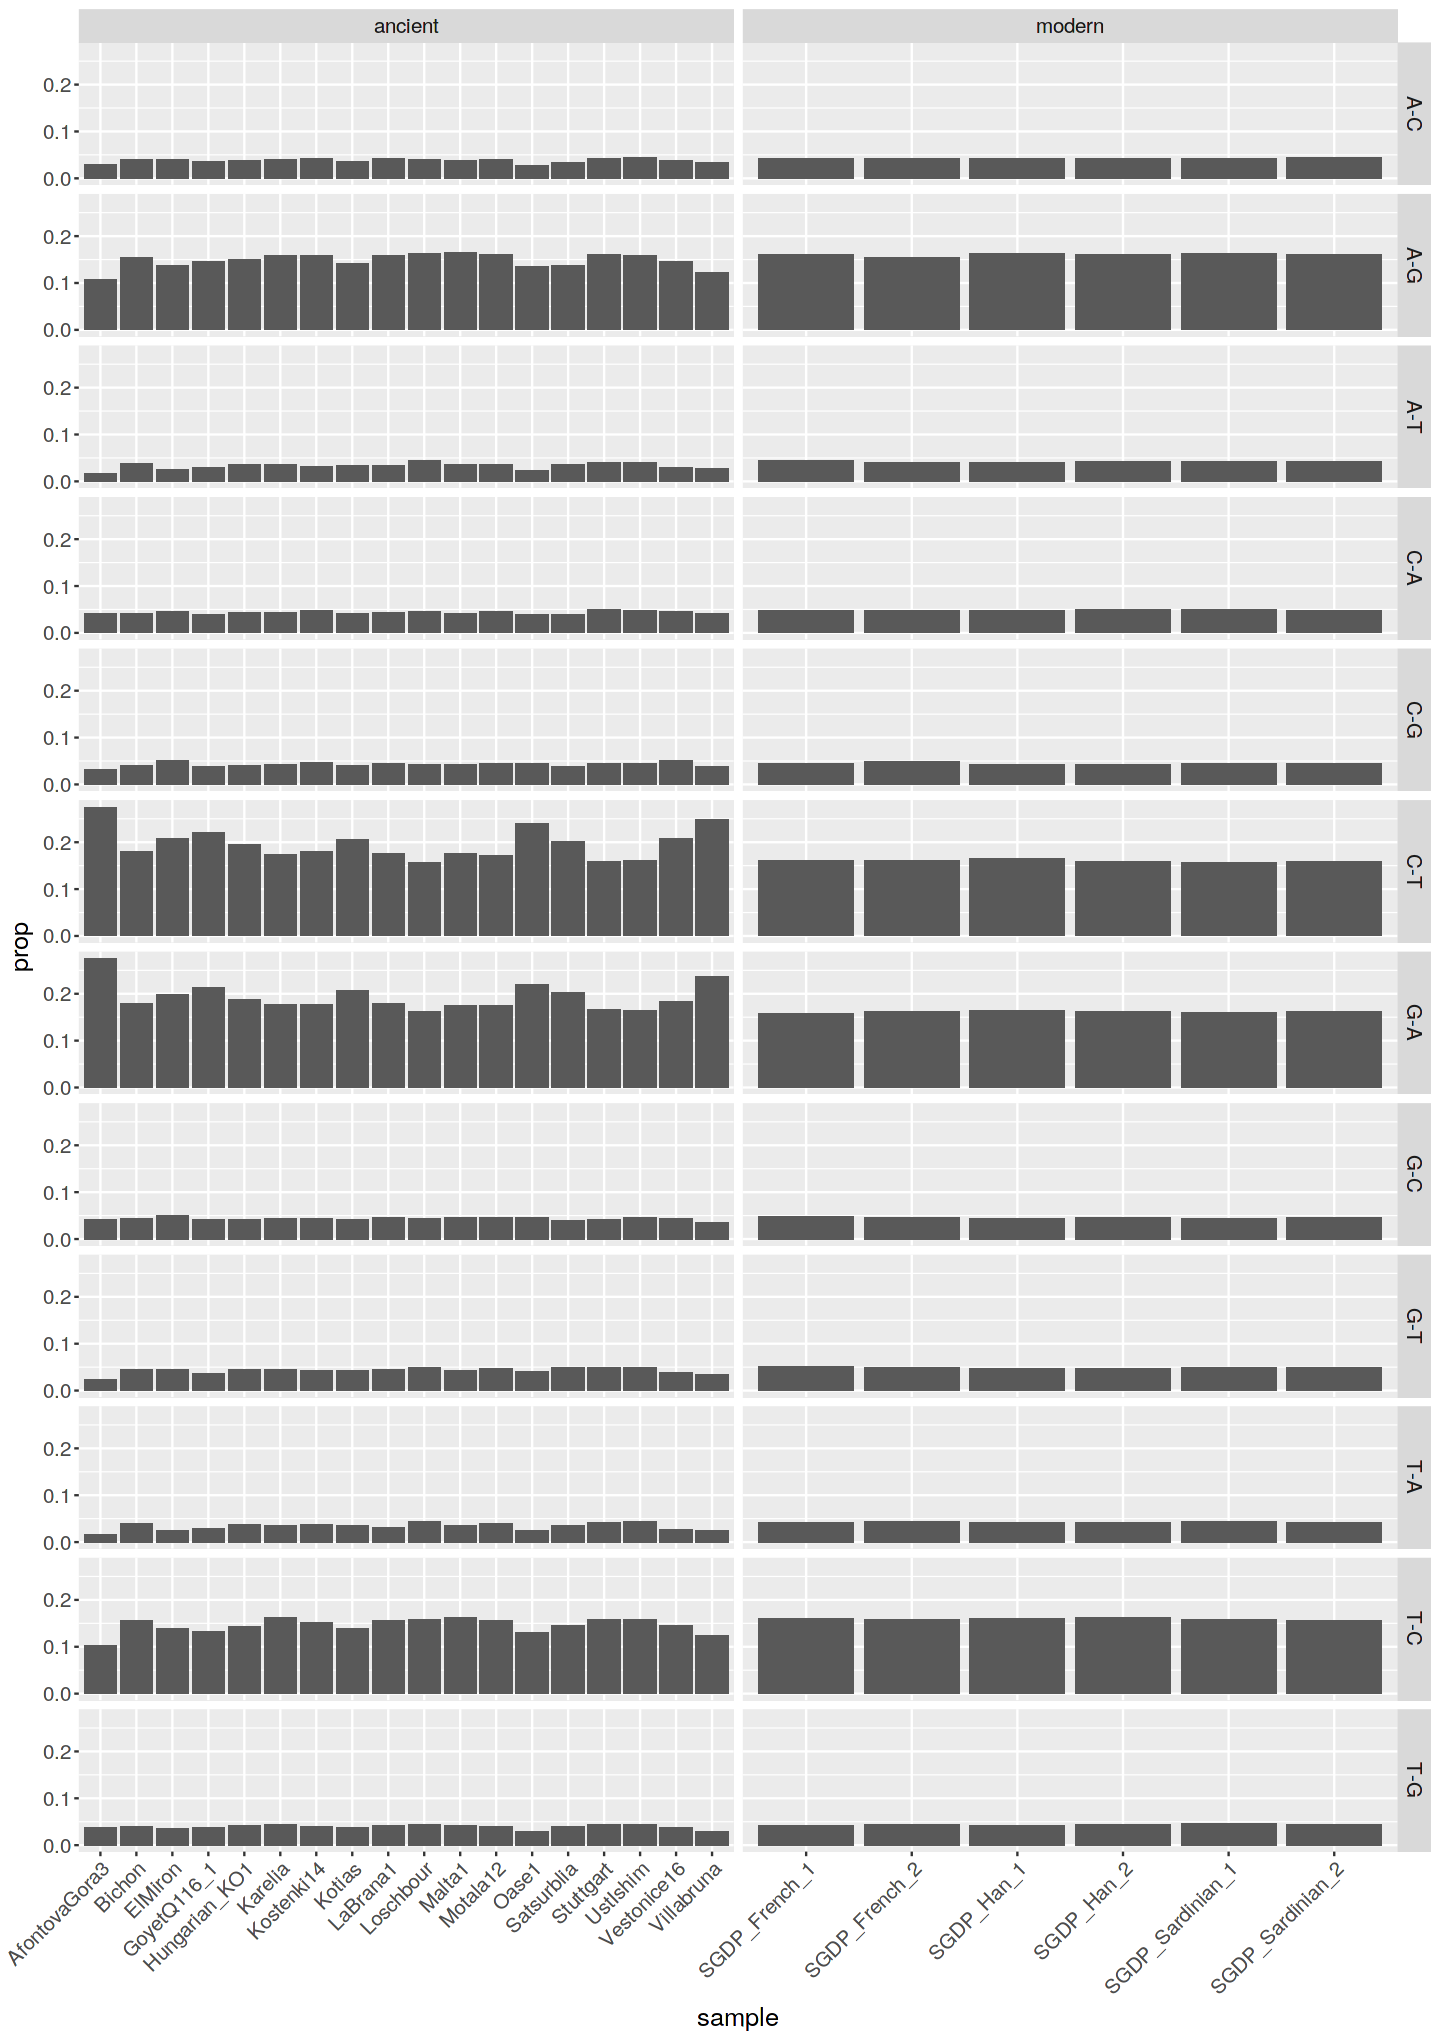

In [8]:
options(repr.plot.width=12, repr.plot.height=17)

subst_rates %>%
filter(total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

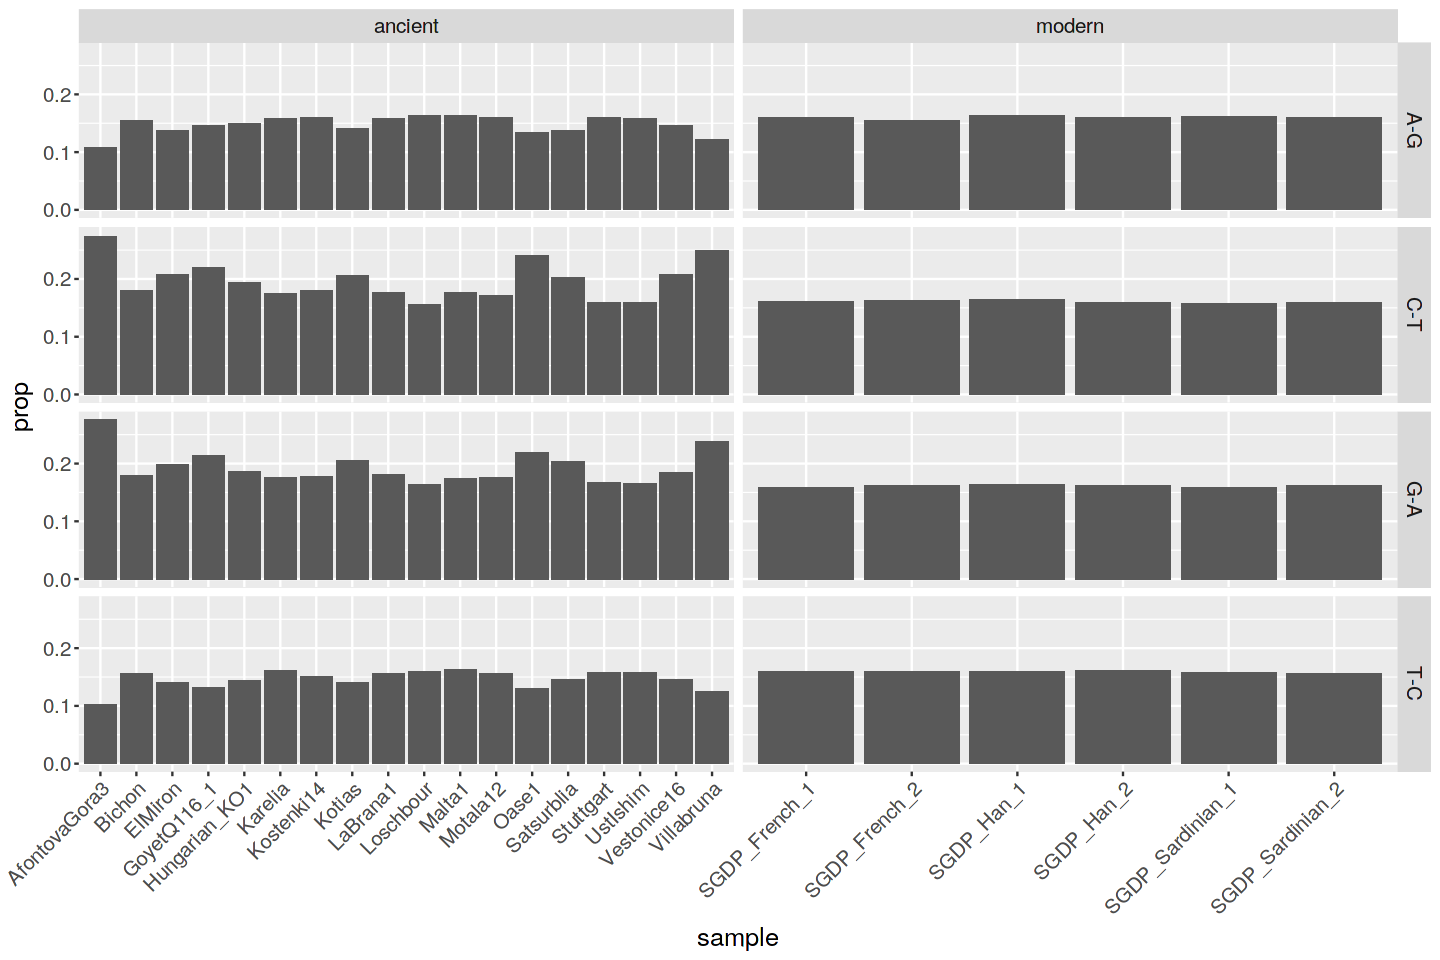

In [9]:
options(repr.plot.width=12, repr.plot.height=8)

subst_rates %>%
filter(subst %in% c("C-T", "G-A", "T-C", "A-G"), total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

We can clearly see which samples have not been treated with UDG or which have a different library preparation.

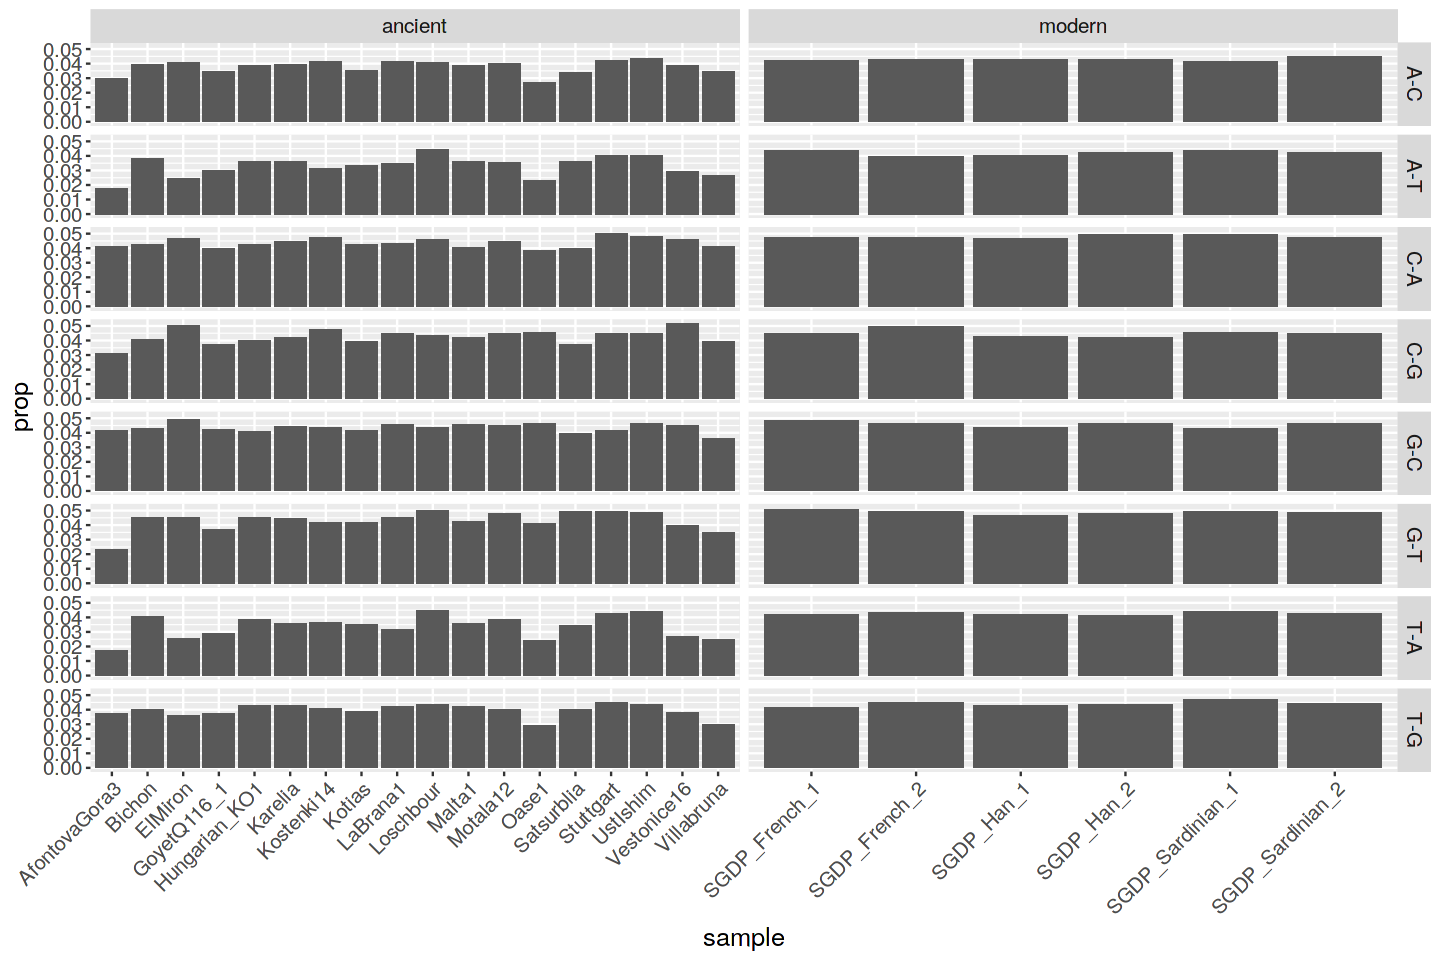

In [10]:
options(repr.plot.width=12, repr.plot.height=8)

subst_rates %>%
filter(! subst %in% c("C-T", "G-A", "T-C", "A-G"), total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

# How does all this affect the Neanderthal ancestry estimates?

In [11]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [12]:
merged <- load_dataset("../clean_data/ice_age.tsv",
                       "../clean_data/sgdp.tsv",
                       "../clean_data/archaics.tsv",
                       filter_damage=FALSE,
                       metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt")

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message in one_of(sgdp_info$name):
"Unknown variables: `S_Australian_1`, `S_Australian_5`"Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),

In [13]:
ages <-
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  bind_rows(tibble(name=c("French_1", "French_2", "Sardinian_1", "Sardinian_2"),
                   age=rep(0L, 4))) %>%
  mutate(post_admixture=as.integer(55000 - age))

sample_names <- colnames(merged)[colnames(merged) %in% ages$name]

Parsed with column specification:
cols(
  name = col_character(),
  age = col_integer()
)


In [16]:
# calculate Nea. ancestry using all sites
nea_ancestry_all <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(merged, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="all_sites")

# calculate Nea. ancestry after removing transitions
tv_only <- remove_transitions(merged)
nea_ancestry_tv <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(tv_only, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="removed_transitions")


#
# Remove SNPs that could be enriched for aDNA errors.
#
remove_ct_ga <- function(snps) {
    filter(snps, !(
        (ref == "C" & alt == "T") |
        (ref == "G" & alt == "A")

    ))
}

# calculate Nea. ancestry after removing C->T and G->A substitutions
ct_ga_only <- remove_ct_ga(merged)
nea_ancestry_ct_ga <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(ct_ga_only, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="removed_ct_and_ga")

nea_ancestry <- bind_rows(nea_ancestry_all, nea_ancestry_tv, nea_ancestry_ct_ga)

In [15]:
# removing C-T, G-A, T-C, A-G substitutions
filter(nea_ancestry, name == "Oase1")

name,nea,missing,age,post_admixture,set
Oase1,0.07386707,0.921265,39610,15390,all_sites
Oase1,0.05881378,0.921265,39610,15390,removed_transitions
Oase1,0.06451907,0.921265,39610,15390,removed_ct_and_ga


### Plot the rates of missing data

In [21]:
missing_cutoff <- 0.98

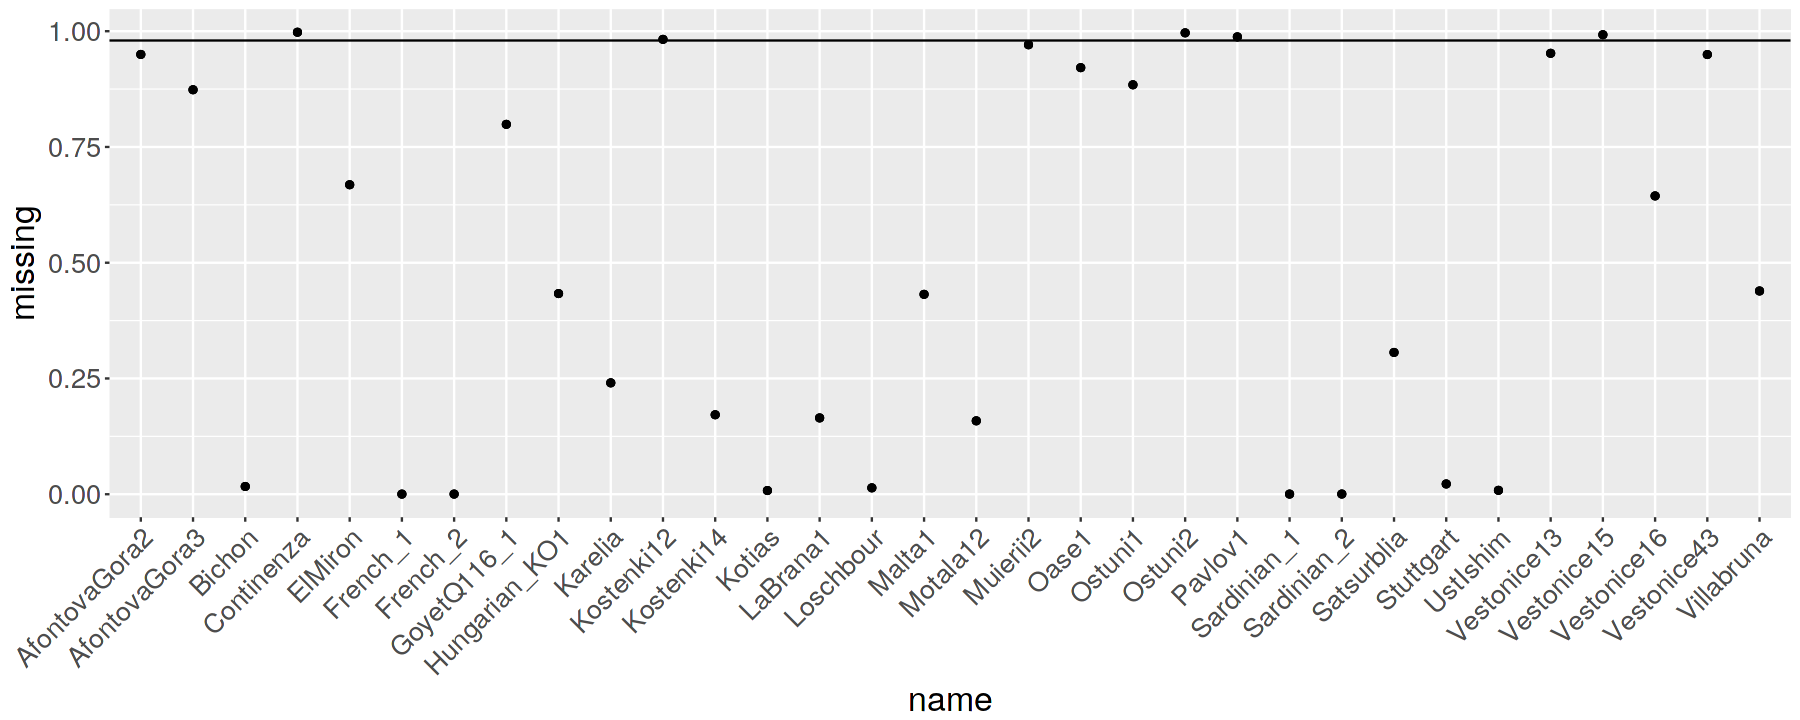

In [22]:
options(repr.plot.width=15, repr.plot.height=6)

nea_ancestry %>%
group_by(name, missing) %>%
ggplot(aes(name, missing)) +
    geom_point()+
    theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1)) +
    geom_hline(yintercept=missing_cutoff)

### Plot the differences in Nea. estimates for filtered and all sites

In [23]:
diffs <- nea_ancestry %>%
  group_by(name) %>%
  spread(set, nea) %>%
  mutate(difference=abs(all_sites - removed_transitions))
diffs$name <- factor(diffs$name, levels=diffs$name[order(diffs$difference)])

In [24]:
head(diffs)

name,missing,snp_count,age,post_admixture,all_sites,removed_ct_and_ga,removed_transitions,difference
AfontovaGora2,0.9498528974,24272,16710,38290,0.02072347,0.02038473,0.01966255,1.060919e-03
AfontovaGora3,0.8735620310,61198,16710,38290,0.03330174,0.02075329,0.01989076,1.341099e-02
Bichon,0.0167308519,475918,13665,41335,0.02604650,0.02387283,0.02305058,2.995926e-03
Continenza,0.9978079237,1061,10855,44145,0.02921772,0.02926829,0.02000000,9.217719e-03
ElMiron,0.6684055899,160497,18720,36280,0.02850521,0.02606129,0.02486059,3.644620e-03
French_1,0.0002644541,483888,0,55000,0.01814263,0.01842320,0.01816022,1.759666e-05


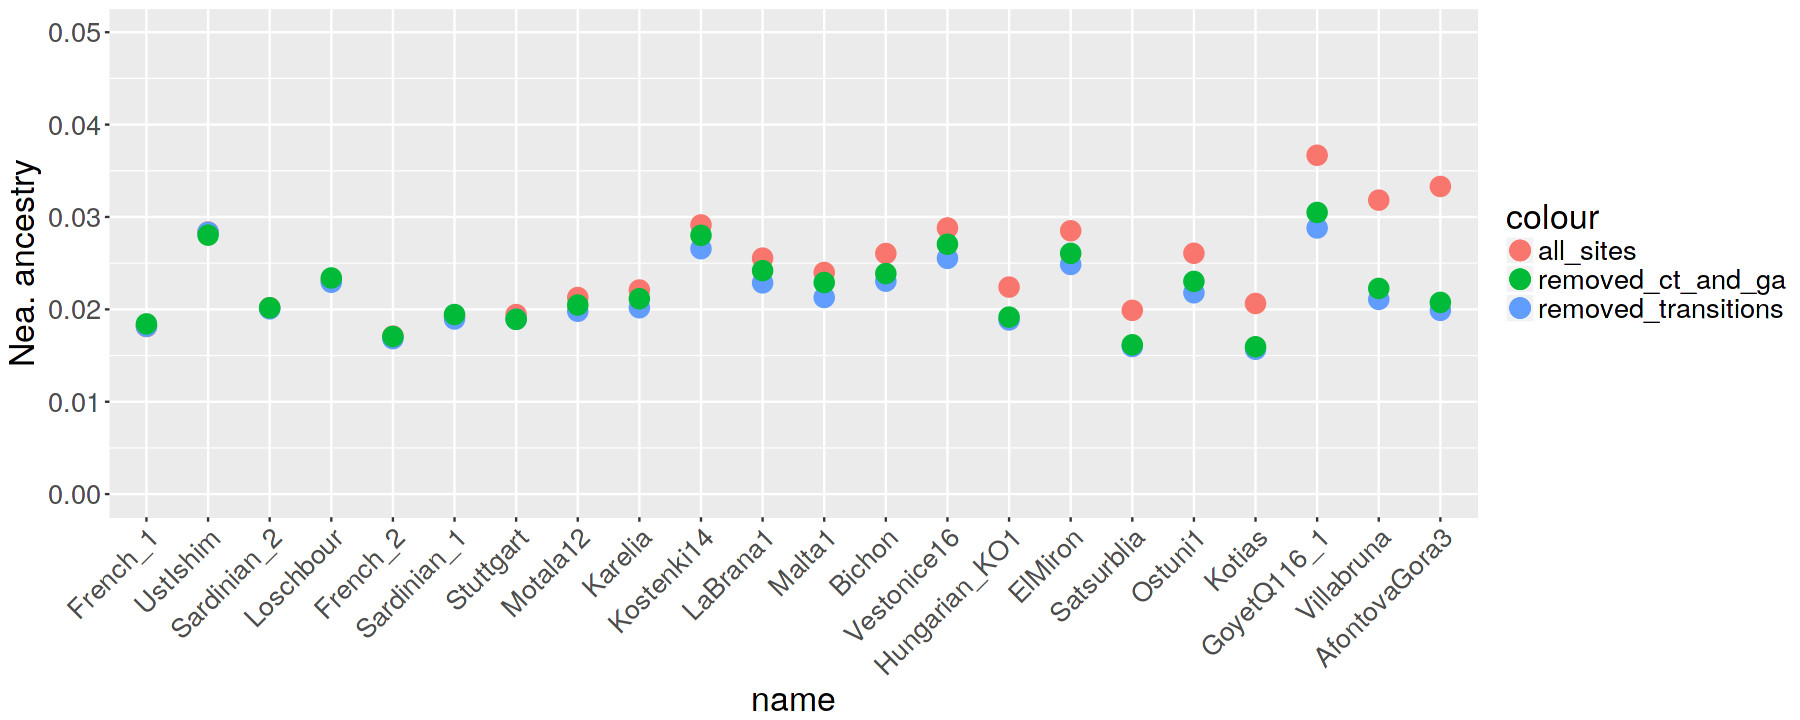

In [25]:
options(repr.plot.width=15, repr.plot.height=6)

filter(diffs, missing < 0.90) %>%
ggplot() +
  geom_point(aes(name, all_sites, color="all_sites"), size=5) +
  geom_point(aes(name, removed_transitions, color="removed_transitions"), size=5) +
  geom_point(aes(name, removed_ct_and_ga, color="removed_ct_and_ga"), size=5) +
  ylim(0, 0.05) + ylab("Nea. ancestry") +
  theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1)) 

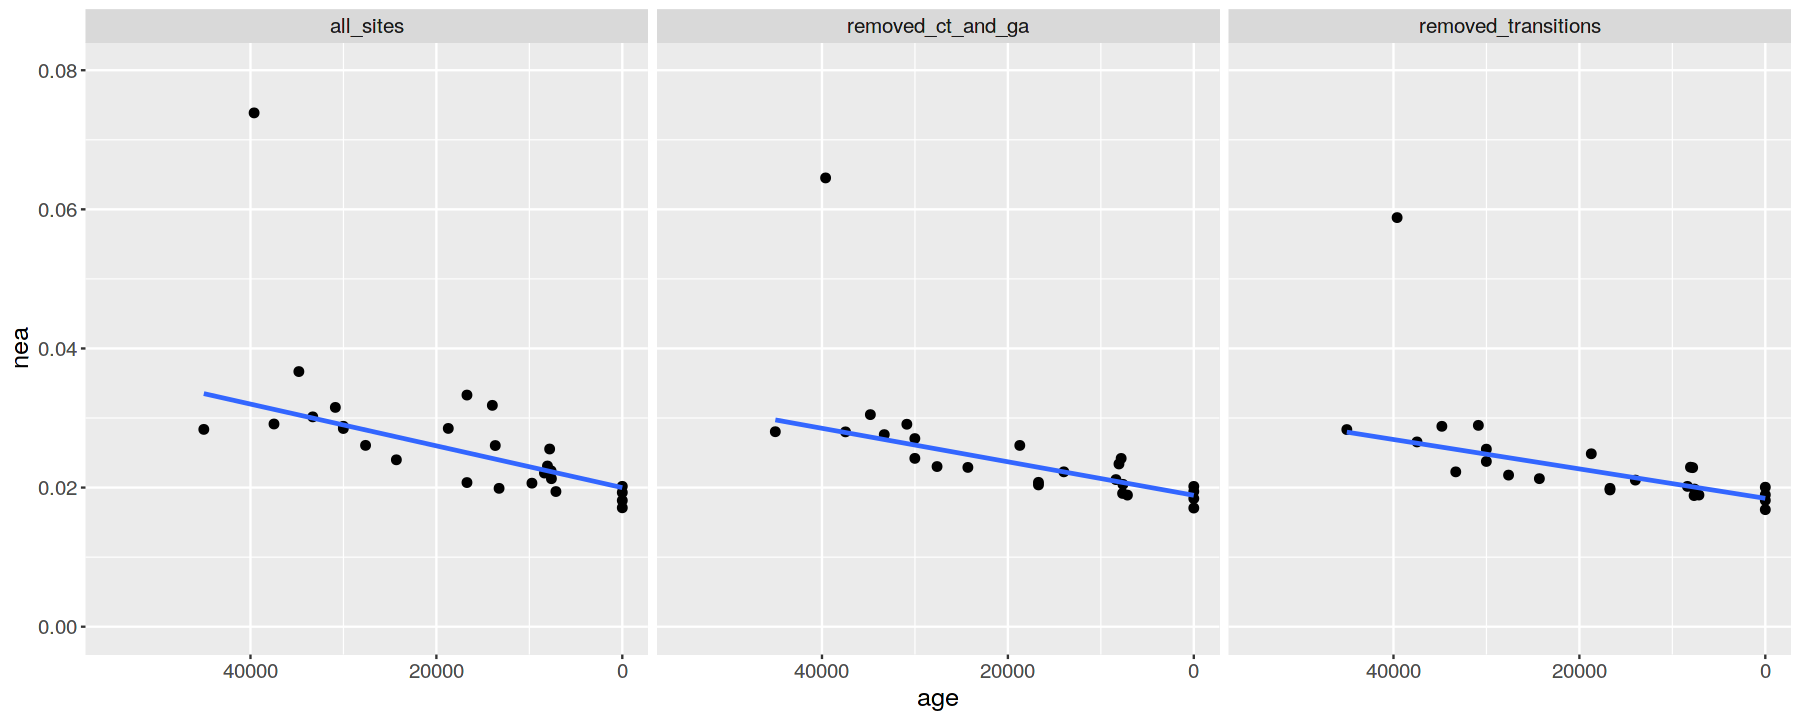

In [26]:
options(repr.plot.width=15, repr.plot.height=6)

filter(nea_ancestry,
       missing < missing_cutoff,
       (set == "all_sites" | !name %in% c("Satsurblia", "Kotias", "Bichon"))) %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=2) +
  lims(y=c(0, 0.08), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", se=FALSE, data=filter(., name != "Oase1")) +
  facet_grid(. ~ set) +
  theme(text=element_text(size=15)) }

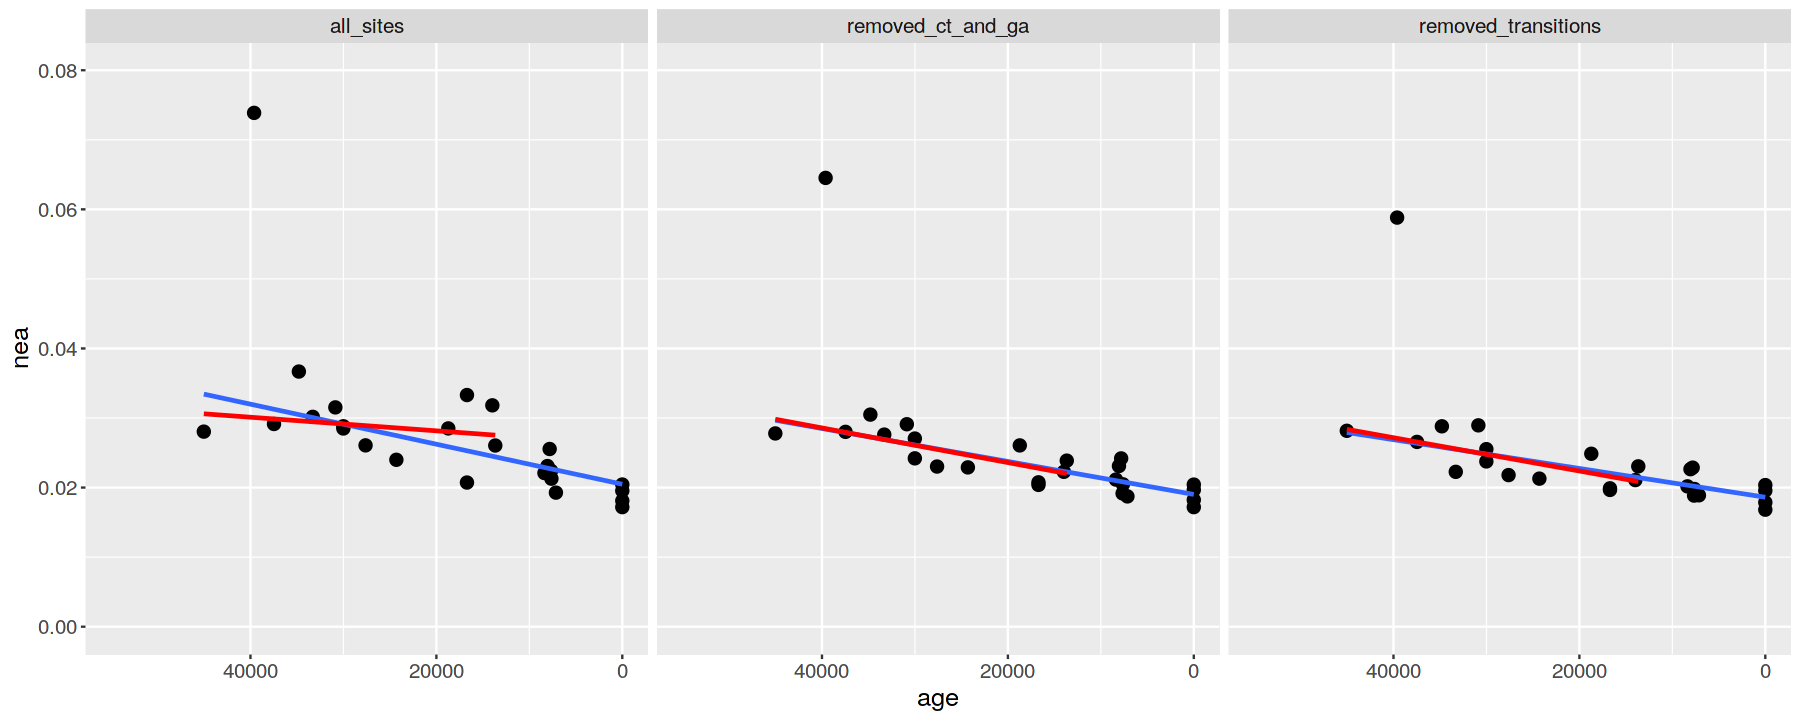

In [54]:
options(repr.plot.width=15, repr.plot.height=6)

filter(nea_ancestry,
       missing < missing_cutoff,
       (set == "all" | !name %in% c("Satsurblia", "Kotias"))) %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=3) +
  lims(y=c(0, 0.08), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", se=FALSE, data=filter(., name != "Oase1")) +
  geom_smooth(aes(age, nea), alpha=0.2, color="red", method="lm", se=FALSE, data=filter(., name != "Oase1", age > 10000)) +
  facet_grid(. ~ set) +
  theme(text=element_text(size=15))
}

## Write the new Nea. estimates to a table

In [29]:
options(repr.plot.width=6, repr.plot.height=4)

filter(nea_ancestry,
       set == "removed_transitions",
       !name %in% c("Oase1", "Satsurblia", "Kotias", "Bichon"),
       missing < missing_cutoff) %>% 
select(name, nea, age, snp_count) %>% 
write_tsv("../output/nea_estimates.txt")

### The linear regression line seems to have a lower slope than before - why is that?

I think it's because in the previous version of the Nea. estimation code (the one used for the Fachbeirat presentation), I incorrectly filtered out just C->T and G->A, but not T->C and A->G.

Let's see if we get the same results if I use the C->T/G->A incorrect filtering.

In [23]:
old_estimates <- read_tsv("../old_stuff/new_estimates.tsv") %>% mutate(set="old_estimates")

Parsed with column specification:
cols(
  name = col_character(),
  nea = col_double(),
  missing = col_double(),
  age = col_integer(),
  post_admixture = col_integer(),
  set = col_character()
)


In [24]:
new_estimates <- filter(nea_ancestry, set == "removed_ct_and_ga") %>% mutate(set="new_estimates")
correct_estimates <- filter(nea_ancestry, set == "removed_transitions") %>% mutate(set="correct")

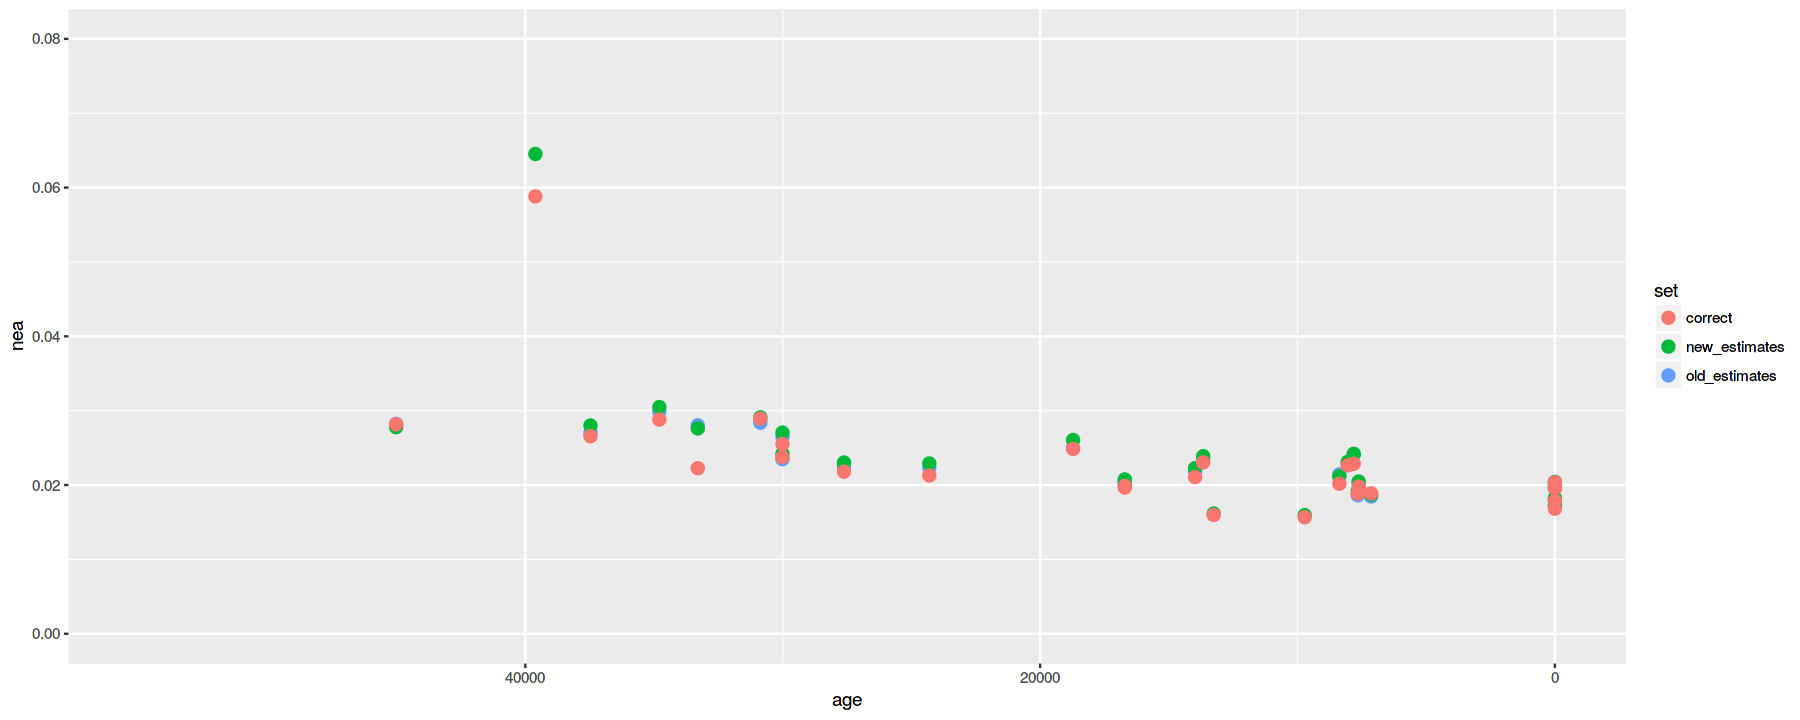

In [25]:
ggplot(bind_rows(old_estimates, new_estimates, correct_estimates) %>% filter(missing < missing_cutoff),
       aes(age, nea, color=set)) +
    geom_point(size=3) + ylim(0, 0.08) + xlim(55000, 0)